
# <font color='red'>**ATENÇÃO**

Para a execução desse notebook será necessária a "montagem" do google drive para acesso de leitura e gravação de arquivos.
A variável **`path`** deve ser preenchida com o valor do diretório que estiver localizado o notebook.
</font>

# Introdução ao MapReduce

Este notebook tem o objetivo de apresentar os fundamentos práticos do modelo de programação "MapReduce". 

Inicialmente serão apresentados os conceitos das funções `map`, `filter` e `reduce` presentes nativamente no Python e em seguida o clássico exemplo de contagem de palavras em um texto.

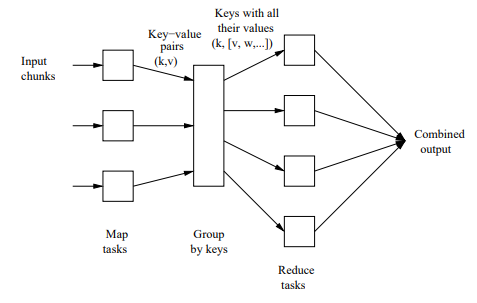

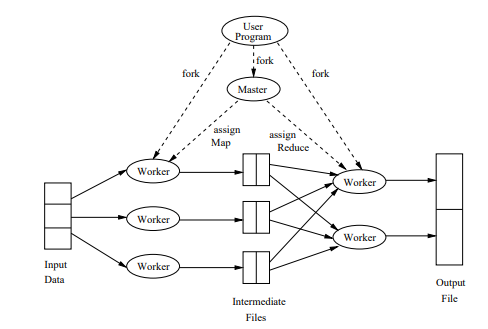

# Função `map`

Em Python, a operação nativa `map` aplica uma função sobre cada elemento de um vetor. Por exemplo, para somar 2 a cada elemento de um vetor, podemos executar o seguinte código:

In [202]:
# Criando um função que some 2 a um elemento
def f(x):
    return x+2

In [203]:
f(6)

8

In [204]:
# Array de teste criado
array = [1,2,4,7,8,9]

In [205]:
# Aplicação da função sobre os elementos do array usando a função "map"
# map(funcao, dados)
resultado  = list(map(f, array))

In [206]:
type(resultado)

list

In [207]:
for i in resultado:
  print(i)

3
4
6
9
10
11


In [208]:
# Com função anônima
resultado = list(map(lambda x: x*2, array))
print(resultado)

[2, 4, 8, 14, 16, 18]


Mais informações sobre a função `map` podem ser obtidas no post:
https://medium.com/horadecodar/express%C3%B5es-lambda-em-python-com-map-reduce-e-filter-a391368ae886 

# Função `filter`

A função `filter`, como o nome sugere, filtra os elementos de uma coleção, de acordo com uma função passada como argumento.

In [209]:
# Função para retornar o valor se um número for par
def retornar_se_numero_par(x):
  if (x%2 == 0):
    return x 

In [210]:
retornar_se_numero_par(9)

In [211]:
# Array de teste criado
array = [1,2,4,7,8,9]
resultado = list(filter(retornar_se_numero_par,array))

In [212]:
for i in resultado:
  print(i)

2
4
8


In [213]:
# se optar por usar uma função anônima (lambda)
list(filter(lambda x: x%2 == 0, array))

[2, 4, 8]

# Função `reduce`

Em python, a função nativa `reduce` (módulo functools) aplica uma função de agregação sobre um vetor, da direita para a esquerda. A função de agregação possui dois parâmetros, os quais são usados como operandos da função agregadora. 


In [214]:
# Função para comparar dois números retornando o maior deles
def retornar_maior(x,y):
  if (x > y):
    return x
  else:
    return y

In [215]:
from functools import reduce

reduce(retornar_maior, array)

9

Outro exemplo usando função anônima:

In [216]:
# Somar todos os elementos de um array
reduce(lambda x,y: x + y, array)

31

# Modelo de programação MapReduce

No modelo MapReduce, o objetivo do **"Mapper"** é transformar elementos de uma 
lista em tuplas do tipo (chave, valor). 

O código abaixo descreve uma função que transforma uma linha em um conjunto de tuplas representando a ocorrência de uma palavra nesta linha.

In [217]:
def mapper(linha):
  palavras = linha.split()  # Divide uma linha em palavras
  for palavra in palavras:
      print('%s\t%d' % (palavra, 1))

In [218]:
trecho_texto = """Uma noite destas, vindo da cidade para o Engenho Novo, encontrei no
trem da Central um rapaz aqui do bairro, que eu conheço de vista e
de chapéo."""

In [219]:
mapper(trecho_texto)

Uma	1
noite	1
destas,	1
vindo	1
da	1
cidade	1
para	1
o	1
Engenho	1
Novo,	1
encontrei	1
no	1
trem	1
da	1
Central	1
um	1
rapaz	1
aqui	1
do	1
bairro,	1
que	1
eu	1
conheço	1
de	1
vista	1
e	1
de	1
chapéo.	1


Como as etapas do MapReduce são sempre intercaladas com a gravação dos arquivos em disco, vamos alterar a função **mapper** para salvar o resultado em um arquivo texto no drive. 

In [220]:
path = 'C:/Users/tassi/OneDrive - CESB - Centro de Educação Superior de Brasilia LTDA/Documentos/GitHub/Faculdade/Processamento de dados massivos/'
def mapper(linha):
  arquivo = open(path + "arquivo_saida_mapper.txt", 'w')
  palavras = linha.split()  # Divide uma linha em palavras
  for palavra in palavras:
      # Para cada palavra, escreve escreve uma tupla (chave, valor) onde chave é a palavra e o valor é 1
      arquivo.write('%s\t%d\n' % (palavra, 1))
  arquivo.close()

Executando novamente sobre o texto de teste será gerado o arquivo "arquivo_saida_mapper.txt" com o resultado da primeira etapa do processamento.

In [221]:
mapper(trecho_texto)

Salvando o resultado em um arquivo.

In [222]:
mapper(trecho_texto)

Dessa forma estaria criada a saída para a primeira parte do processamento "MapReduce".

## Shuffle e Ordenação

O resultado do Mapper passa por uma operação onde os resultados com a mesma chave são agrupados em vetores. O resultado desta operação está listada no dicionário abaixo:

In [223]:
from collections import defaultdict

resultado_intermediario = defaultdict(list)
with open(path + "arquivo_saida_mapper.txt") as arquivo:
    for linha in arquivo:
        chave, valor = linha.split()
        resultado_intermediario[chave].append(int(valor))
dict(resultado_intermediario)

{'Uma': [1],
 'noite': [1],
 'destas,': [1],
 'vindo': [1],
 'da': [1, 1],
 'cidade': [1],
 'para': [1],
 'o': [1],
 'Engenho': [1],
 'Novo,': [1],
 'encontrei': [1],
 'no': [1],
 'trem': [1],
 'Central': [1],
 'um': [1],
 'rapaz': [1],
 'aqui': [1],
 'do': [1],
 'bairro,': [1],
 'que': [1],
 'eu': [1],
 'conheço': [1],
 'de': [1, 1],
 'vista': [1],
 'e': [1],
 'chapéo.': [1]}

O conteúdo mostrado acima é o resultado do processamento da etapa de `shuffle`, na qual, como foi comentado na aula, os pares "chave-valor" gerados na fase "Map" são agrupados segundo uma mesma chave.

Esse processamento será incluído dentro de uma função que fará a leitura de um arquivo e gerará um outro para ser processado na fase seguinte.

In [224]:
def shuffle(path, nome_arquivo_mapper):
  resultado_intermediario = defaultdict(list)
  with open(path + nome_arquivo_mapper) as arquivo_entrada:
    for linha in arquivo_entrada:
      chave, valor = linha.split()
      resultado_intermediario[chave].append(int(valor))
  arquivo_entrada.close()
  resultado = dict(resultado_intermediario)
  arquivo_shuffle = open(path + "arquivo_saida_shuffle.txt", 'w')
  arquivo_shuffle.write(str(resultado))
  arquivo_shuffle.close()

In [225]:
shuffle(path, 'arquivo_saida_mapper.txt')

A etapa "Reduce" vai consolidar os resultados e fazer o tratamento que seja necessário. No caso, o tratamento será a soma da quantidade de ocorrências de cada palavra.

In [226]:
def somar_elementos(x,y):
  return x+y

In [227]:
from functools import reduce

dict_result = {}
for chave, lista in resultado_intermediario.items():
    dict_result[chave] = reduce(somar_elementos, lista)
dict_result

{'Uma': 1,
 'noite': 1,
 'destas,': 1,
 'vindo': 1,
 'da': 2,
 'cidade': 1,
 'para': 1,
 'o': 1,
 'Engenho': 1,
 'Novo,': 1,
 'encontrei': 1,
 'no': 1,
 'trem': 1,
 'Central': 1,
 'um': 1,
 'rapaz': 1,
 'aqui': 1,
 'do': 1,
 'bairro,': 1,
 'que': 1,
 'eu': 1,
 'conheço': 1,
 'de': 2,
 'vista': 1,
 'e': 1,
 'chapéo.': 1}

Para imprimir o resultado ordenado:

In [228]:
for item  in sorted(dict_result, key = dict_result.get, reverse = True):
    print (item, dict_result[item])

da 2
de 2
Uma 1
noite 1
destas, 1
vindo 1
cidade 1
para 1
o 1
Engenho 1
Novo, 1
encontrei 1
no 1
trem 1
Central 1
um 1
rapaz 1
aqui 1
do 1
bairro, 1
que 1
eu 1
conheço 1
vista 1
e 1
chapéo. 1


Seguindo o padrão anterior e criando uma função para ler o arquivo de saída da etapa anterior e gerar um novo:

In [229]:
def reducer(path, nome_arquivo_shuffle, funcao_reduce):
  arquivo = open(path + nome_arquivo_shuffle,'r')
  conteudo_entrada = arquivo.read()
  dict_entrada = eval(conteudo_entrada)
  arquivo.close()
  dict_result = {}
  for chave, lista in dict_entrada.items():
    dict_result[chave] = reduce(funcao_reduce, lista)
  arquivo_reduce = open(path + "arquivo_saida_reduce.txt", 'w')
  for item  in sorted(dict_result, key = dict_result.get, reverse = True):
    arquivo_reduce.write(item + ' ' + str(dict_result[item]))
    arquivo_reduce.write("\n")
  arquivo_reduce.close()

In [230]:
arquivo = open(path + "arquivo_saida_shuffle.txt",'r')
conteudo_entrada = arquivo.read()

In [231]:
eval(conteudo_entrada)

{'Uma': [1],
 'noite': [1],
 'destas,': [1],
 'vindo': [1],
 'da': [1, 1],
 'cidade': [1],
 'para': [1],
 'o': [1],
 'Engenho': [1],
 'Novo,': [1],
 'encontrei': [1],
 'no': [1],
 'trem': [1],
 'Central': [1],
 'um': [1],
 'rapaz': [1],
 'aqui': [1],
 'do': [1],
 'bairro,': [1],
 'que': [1],
 'eu': [1],
 'conheço': [1],
 'de': [1, 1],
 'vista': [1],
 'e': [1],
 'chapéo.': [1]}

In [232]:
reducer(path, "arquivo_saida_shuffle.txt", somar_elementos)

O arquivo final `arquivo_saida_reduce.txt` apresenta a relação de palavras e respectivas quantidades de ocorrências no texto, ordenadas de forma decrescente.

# Extendendo para um arquivo maior

Vamos executar os mesmos passos para um arquivo baixado na web.

Será o livro "Dom Casmurro", de Machado de Assis, obtido em http://www.gutenberg.org/files/55752/55752-8.txt

Para baixar o arquivo direto da web e salvar no drive, vamos utilizar a biblioteca `requests`

In [233]:
import requests

request = requests.get('http://www.gutenberg.org/files/55752/55752-8.txt')

In [234]:
arquivo_base = open(path + "arquivo_dom_casmurro.txt", 'w')
arquivo_base.write(str(request.text))
arquivo_base.close()

Como a função `mapper` criada não está preparada para receber um arquivo, vamos criar uma outra que atenda a essa necessidade.

In [235]:
from unidecode import unidecode

def mapper_recebendo_arquivo(path, nome_arquivo_entrada):
  arquivo_entrada = open(path + nome_arquivo_entrada,'r')
  arquivo_saida = open(path + "arquivo_saida_mapper.txt", 'w')
  palavras = arquivo_entrada.read().split()  # Divide uma linha em palavras
  for palavra in palavras:
      # Para cada palavra, escreve escreve uma tupla (chave, valor) onde chave é a palavra e o valor é 1
      arquivo_saida.write('%s\t%d\n' % (unidecode(palavra.lower()), 1))
  arquivo_saida.close()

In [236]:
mapper_recebendo_arquivo(path, "arquivo_dom_casmurro.txt")

Pode ser verificado que foi criado o arquivo `saida_mapper.txt` com o resultado do processamento da etapa Map.

A partir de agora, o processo é o mesmo do que ocorreu no exemplo anterior.

In [237]:
shuffle(path, 'arquivo_saida_mapper.txt')

In [238]:
reducer(path, "arquivo_saida_shuffle.txt", somar_elementos)

# Exercícios

## Para qualquer alteração no resultado do processamento, deve-se alterar as funções pertencentes às etapas **Map** ou **Reduce**. 
## Nos exercícios abaixo, altere as funções para realizar as tarefas indicadas.

1. Altere o código para que as palavras sejam desconsideradas a acentuação e todas as letras estejam no formato minúsculo.
1. Altere o código da função `reducer` para imprimir o número total de palavras no texto.
2. Alterar o código para imprimir a palavra que mais se repete, bem como a quantidade.
3. Implemente o ajuste para que as `stopwords` sejam desconsideradas e repita os itens 1 e 2.
2. Altere o código do reducer para imprimir o percentual de ocorrências de cada palavra no texto (Term Frequency). Assuma que o número de palavras no texto já é conhecido.

## Resolução (1)
Para a desconsideração da acentuação, é necessário utilizar a biblioteca "unidecode" que não está disponível no `colab`. Dessa forma terá que ser intalada toda vez que o notebook for executado.

In [239]:
# instalação da 'unidecode'
!pip install unidecode

In [240]:
# Alterando a função mapper para considerar todas as letras minúsculas e sem acento
from unidecode import unidecode

def mapper_normalizando_palavras(path, nome_arquivo_entrada):
  arquivo_entrada = open(path + nome_arquivo_entrada,'r')
  arquivo_saida = open(path + "arquivo_saida_mapper.txt", 'w')
  palavras_bruto = arquivo_entrada.read().split()  # Divide uma linha em palavras
  palavras_normalizadas = map(lambda x: unidecode(x.lower()),palavras_bruto)
  for palavra in palavras_normalizadas:
      # Para cada palavra, escreve escreve uma tupla (chave, valor) onde chave é a palavra e o valor é 1
      arquivo_saida.write((palavra) + ' 1\n')
  arquivo_saida.close()

In [241]:
mapper_normalizando_palavras(path, 'arquivo_dom_casmurro.txt')
shuffle(path, 'arquivo_saida_mapper.txt')
reducer(path, "arquivo_saida_shuffle.txt", somar_elementos)

## Resolução (2) e (3)

In [242]:
def reducer_imprime_total_palavras(path, nome_arquivo_shuffle, funcao_reduce):
  arquivo = open(path + nome_arquivo_shuffle,'r')
  conteudo_entrada = arquivo.read()
  dict_entrada = eval(conteudo_entrada)
  arquivo.close()
  dict_result = {}
  numero_palavras = 0
  for chave, lista in dict_entrada.items():
    dict_result[chave] = reduce(funcao_reduce, lista)
    numero_palavras += reduce(funcao_reduce, lista)
  arquivo_reduce = open(path + "arquivo_saida_reduce.txt", 'w')
  for item  in sorted(dict_result, key = dict_result.get, reverse = True):
    arquivo_reduce.write(item + ' ' + str(dict_result[item]))
    arquivo_reduce.write("\n")
  arquivo_reduce.close()
  print("O número total de palavras é: %d"%(numero_palavras))
  palavra_mais_frequente = sorted(dict_result, key = dict_result.get, reverse = True)[0]
  print("A palavra que mais se repete é: %s (%d vezes)" % (palavra_mais_frequente, 
                                                           dict_result[palavra_mais_frequente]))

In [243]:
reducer_imprime_total_palavras(path, "arquivo_saida_shuffle.txt", somar_elementos )

O número total de palavras é: 68881
A palavra que mais se repete é: a (2807 vezes)


## Resolução item (3 e 4)
Para a resolução desse item vamos buscar a relação de _stopwords_ em português disponível na biblioteca `ntlk'.

In [244]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords_portuguese = stopwords.words('portuguese')
stopwords_portuguese

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tassi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

In [245]:
# Função para filtrar se a palavra é stopword, fazendo isso sobre palavras já normalizadas
def retornar_se_palavra_nao_stopword(palavra):
  if unidecode(palavra.lower()) not in map(unidecode,stopwords_portuguese):
    return palavra

In [246]:
retornar_se_palavra_nao_stopword('Á')

In [247]:
# Alterando a função mapper para desconsiderar as stopwords
def mapper_filtrando_sem_stopwords(path, nome_arquivo_entrada):
  arquivo_entrada = open(path + nome_arquivo_entrada,'r')
  arquivo_saida = open(path + "arquivo_saida_mapper.txt", 'w')
  palavras_bruto = arquivo_entrada.read().split()  # Divide uma linha em palavras
  palavras_filtradas = list(filter(retornar_se_palavra_nao_stopword,palavras_bruto))
  for palavra in palavras_filtradas:
      # Para cada palavra, escreve escreve uma tupla (chave, valor) onde chave é a palavra e o valor é 1
      arquivo_saida.write(palavra + ' 1\n')
  arquivo_saida.close()
  arquivo_entrada.close()

In [248]:
mapper_filtrando_sem_stopwords(path, "arquivo_dom_casmurro.txt")
shuffle(path, 'arquivo_saida_mapper.txt')
reducer_imprime_total_palavras(path, "arquivo_saida_shuffle.txt", somar_elementos )


O número total de palavras é: 40321
A palavra que mais se repete é: Capitú (204 vezes)


## Resolução (5) 
É com vcs!!

In [249]:
def reducer_calculando_TF(path, nome_arquivo_shuffle, funcao_reduce):
  arquivo = open(path + nome_arquivo_shuffle,'r')
  conteudo_entrada = arquivo.read()
  dict_entrada = eval(conteudo_entrada)
  arquivo.close()
  dict_result = {}
  total_palavras = 40321
  for chave, lista in dict_entrada.items():
    dict_result[chave] = reduce(funcao_reduce, lista)/total_palavras
  arquivo_reduce = open(path + "arquivo_saida_reduce.txt", 'w')
  for item  in sorted(dict_result, key = dict_result.get, reverse = True):
    arquivo_reduce.write(item + ' ' + str(dict_result[item]))
    arquivo_reduce.write("\n")
  arquivo_reduce.close()

In [250]:
reducer_calculando_TF(path, "arquivo_saida_shuffle.txt", somar_elementos )